# Modeling a Time-Variant Random Variable by Using Drift!

In [29]:
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

start = datetime(2016, 9, 1)
end = datetime(2021, 8, 31)
ticker = 'AAPL'
stock = web.DataReader(ticker, 'stooq', start, end)
prices = stock.reset_index().sort_values('Date',ascending=True)['Close'].to_numpy()

In [30]:
prices

array([ 25.027,  25.257,  25.249, ..., 148.6  , 153.12 , 151.83 ])

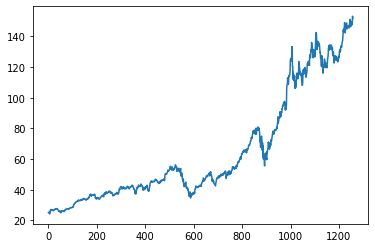

In [31]:
plt.plot(prices)
plt.show()

In [5]:
logs = np.log(prices)

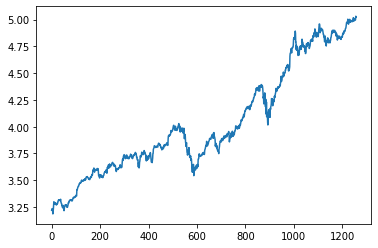

In [6]:
plt.plot(logs)

0.001434213390458498
0.01905342412763582


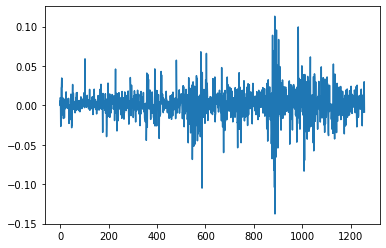

In [7]:
first_diff = np.diff(logs)
print(first_diff.mean())
print(first_diff.std())
plt.plot(first_diff)
plt.show()

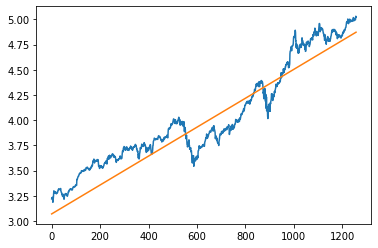

In [9]:
avg_return = first_diff.mean()
avg_logs = np.array([logs[0]+avg_return*i for i in range(len(logs))])

plt.plot(logs)
plt.plot(avg_logs-.15)
plt.show()

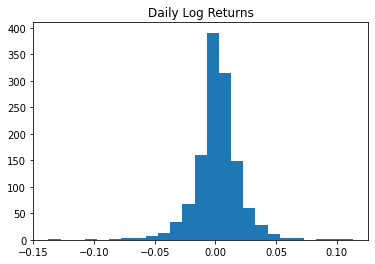

In [10]:
plt.hist(first_diff, bins=25)
plt.title('Daily Log Returns')
plt.show()

In [48]:
avg_return

0.001434213390458498

In [12]:
l = len(prices)
total_return = np.log(prices[-1])-np.log(prices[0])
avg_return = total_return/l
start_exp = np.log(prices[0])

plt.plot(prices)
plt.plot(np.exp(avg_logs-.15))
plt.show()

In [50]:
1 - np.exp(1) / np.exp(1+first_diff.mean())

0.001433185397946235

In [51]:
# An addition of .001 to the exponent translates almost exactly to a .1% increase in value
first_diff.mean()

0.001434213390458498

So let's use this to create a stock that oscillates around a mean that grows exponentially.
We'll model this by making the stock price an exponential function with a parameter in the exponent.
Every day this parameter grows by .001; however the actual value of the stock is a random variable
that we will model similarly to the mean but by bootstrapping.

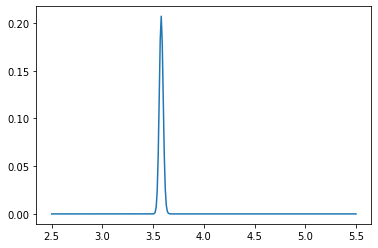

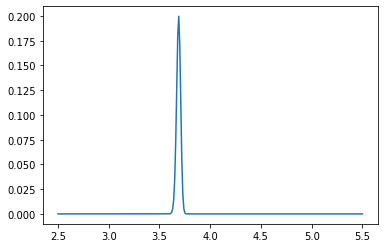

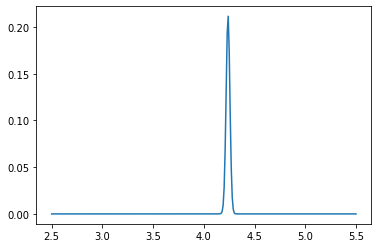

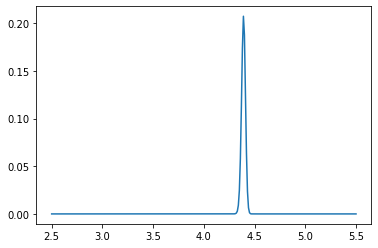

In [34]:
from scipy.stats import norm

# Particle filter
pf_index = np.linspace(2.5, 5.5, 301)
pf = np.full(301, 1./301.) # A completely naive prior
e_values = [(pf_index * pf).sum()]

log_means = [logs[0]]
mean_gain = first_diff.mean()

log_values = [logs[0]]
sigma = first_diff.std()
ps = [norm.pdf(0, loc=0, scale=5*sigma)]

for count in range(1,1000):
    
    accept=False
    log_means.append(log_means[-1] + mean_gain)
    
    # Go through MCMC accept/reject loop
    while not accept:
        new_log_value = log_values[-1] + np.random.choice(first_diff)
        new_p = norm.pdf(new_log_value, loc=log_means[-1], scale=5*sigma)
        if new_p > ps[-1]:
            accept = True
        else:
            p = new_p / ps[-1]
            accept = np.random.choice([True, False], p=[p, 1-p])

    log_values.append(new_log_value)
    old_p = new_p
    
    # Applying the likelihood function
    if count % 1 == 0:

        L = []
        for i in range(len(pf_index)):
            arr = norm.pdf(np.array(log_values[-1:]), loc=pf_index[i], scale=2*sigma)
            L.append(arr.prod())
        L = np.array(L)
        pf = (5 + L) * pf
        # Here we add the drift, which for simplicity we call a random variable X
        # If you look carefully, you'll see that it's convolution
        new_pf = pf.copy()
        for i in range(pf_index.shape[0]):
            # i is our index
            t = pf_index[i]
            t_minus_tau = t - pf_index
            P_X = norm.pdf(t_minus_tau, loc=0, scale=mean_gain*np.sqrt(20))
            new_pf[i] = (pf * P_X).sum()

        pf = new_pf / new_pf.sum()
        # And then we normalize the weights so they sum to 1

        new_e_value = (pf*pf_index).sum()
        e_values.append(new_e_value)
    
    if count % 100 == 0:
        plt.plot(pf_index, pf)
        plt.show()

In [36]:
plt.figure(figsize=(16,6))
plt.plot(log_means)
plt.plot(log_values)
plt.plot(range(0,1000),e_values)
plt.plot(range(0,1000),e_values+6*sigma)
plt.plot(range(0,1000),e_values-6*sigma)
plt.legend(['Mean','Log Values','Expected Log Values'])
plt.show()

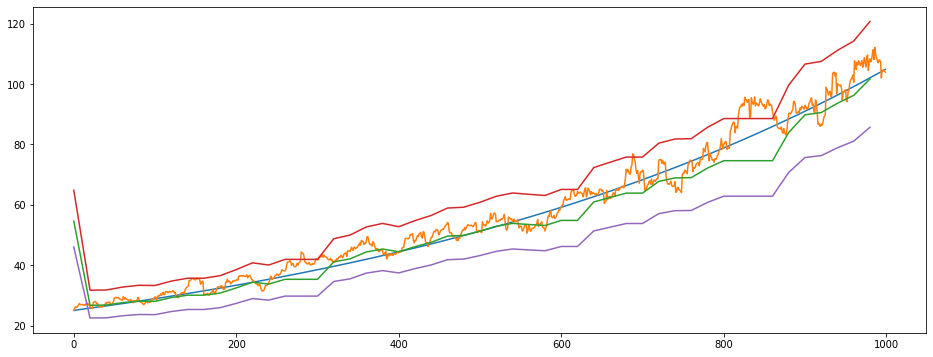

In [103]:
plt.figure(figsize=(16,6))
plt.plot(np.exp(log_means))
plt.plot(np.exp(log_values))
plt.plot(range(0,1000,20),np.exp(e_values))
plt.plot(range(0,1000,20),np.exp(e_values+9*sigma))
plt.plot(range(0,1000,20),np.exp(e_values-9*sigma))

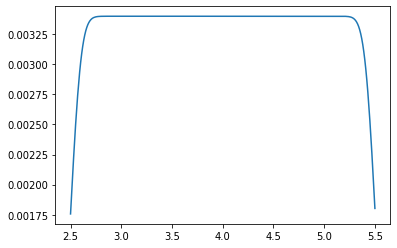

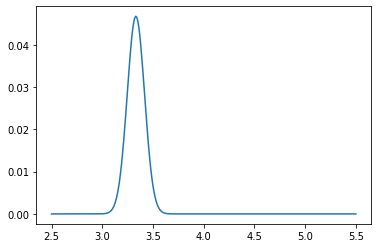

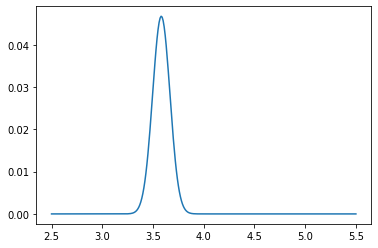

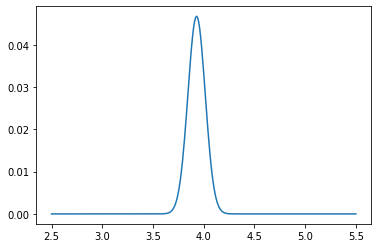

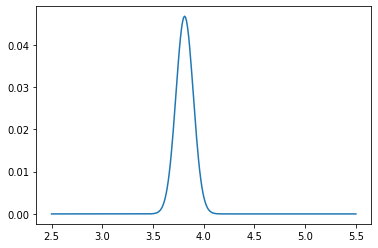

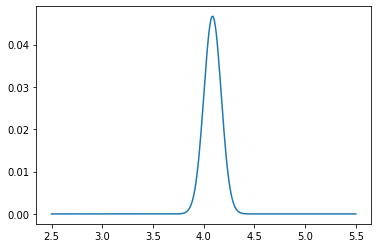

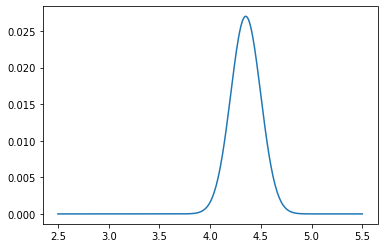

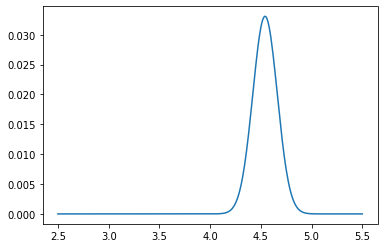

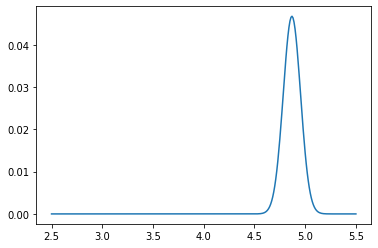

In [23]:
from scipy.stats import norm

pf_index = np.linspace(2.5, 5.5, 301)
pf = np.full(301, 1./301.)
e_values = [(pf_index * pf).sum()]

for count in range(len(logs)):
    
    # Applying the likelihood function
    if count % 20 == 0:

        L = []
        for i in range(len(pf_index)):
            arr = norm.pdf(np.array(logs[count-20:count]), loc=pf_index[i], scale=sigma)
            L.append(arr.prod())
        L = np.array(L)
        pf = (5 + L) * pf
        # Here we add the drift, which for simplicity we call a random variable X
        # If you look carefully, you'll see that it's convolution
        new_pf = pf.copy()
        for i in range(pf_index.shape[0]):
            # i is our index
            t = pf_index[i]
            X = t - pf_index
            P_X = norm.pdf(X, loc=mean_gain, scale=sigma*np.sqrt(20))
            new_pf[i] = (pf * P_X).sum()

        pf = new_pf / new_pf.sum()
        # And then we normalize the weights so they sum to 1

        new_e_value = (pf*pf_index).sum()
        e_values.append(new_e_value)
    
    if count % 100 == 0:
        plt.plot(pf_index, pf)
        plt.show()

In [26]:
plt.figure(figsize=(16,6))
plt.plot(logs)
plt.plot(range(0,len(logs)+20,20), e_values)
plt.plot(range(0,len(logs)+20,20), e_values+6*sigma)
plt.plot(range(0,len(logs)+20,20), e_values-6*sigma)

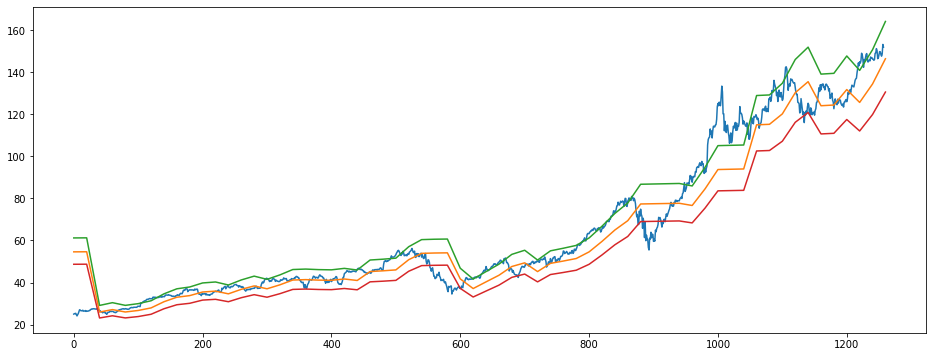

In [28]:
plt.figure(figsize=(16,6))
plt.plot(prices)
plt.plot(range(0,len(logs)+20,20), np.exp(e_values))
plt.plot(range(0,len(logs)+20,20), np.exp(e_values+6*sigma))
plt.plot(range(0,len(logs)+20,20), np.exp(e_values-6*sigma))